In [1]:
import argparse
import os
import numpy as np
import torch
from torch import nn, optim
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
from torch.nn import functional as F
from torchvision.utils import make_grid, save_image
from tqdm import tqdm
from env import Env
from memory import ExperienceReplay
from model import  Encoder, TransitionModel, Decoder
from utils import lineplot, write_video
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import manifold
import pickle

import cv2

#####################################################################
### General
parser = argparse.ArgumentParser(description='GAP')
parser.add_argument('--id', type=str, default='default', help='Experiment ID')
parser.add_argument('--seed', type=int, default=1, metavar='S', help='Random seed')
parser.add_argument('--task_name', type=str, default="easy", metavar='H', help='Task ID')


### Env Specific
parser.add_argument('--env', type=str, default='Pendulum-v0', help='Gym environment')
parser.add_argument('--max-episode-length', type=int, default=100, metavar='T', help='Max episode length')
parser.add_argument('--action-repeat', type=int, default=2, metavar='R', help='Action repeat')

### Memory
parser.add_argument('--experience-size', type=int, default=100000, metavar='D', help='Experience replay size')
parser.add_argument('--seed-episodes', type=int, default=2000, metavar='S', help='Seed episodes')
parser.add_argument('--experience-replay', type=str, default='', metavar='ER', help='Load experience replay')

### Architecture
parser.add_argument('--activation-function', type=str, default='relu', choices=dir(F), help='Model activation function')
parser.add_argument('--hidden-size', type=int, default=200, metavar='H', help='Hidden size')

### Load Trained Model
parser.add_argument('--models', type=str, default='', metavar='M', help='Load model checkpoint')

args = parser.parse_args("--id door_task_1 \
                        --task_name 1 \
                        --env GapBlock-v0 \
                        --hidden-size 256 \
                       --models pretrained_gap_models/gap_block.pth".split())
'''
args = parser.parse_args("--id block_task_1 \
                        --task_name 1 \
                        --env GapBlock-v0 \
                        --hidden-size 256 \
                        --models results/trained_lip_gap_block/models_40000.pth".split())
'''
print(' ' * 26 + 'Options')
for k, v in vars(args).items():
  print(' ' * 26 + k + ': ' + str(v))

  
# Setup
results_dir = os.path.join('results', args.id)
os.makedirs(results_dir, exist_ok=True)
logdir =  os.path.join(results_dir, "logs")
os.makedirs(logdir, exist_ok=True)

np.random.seed(args.seed)
torch.manual_seed(args.seed)
if torch.cuda.is_available():
  args.device = torch.device('cuda')
  torch.cuda.manual_seed(args.seed)
else:
  args.device = torch.device('cpu')
metrics = {'trainsteps': [], 'steps': [], 'episodes': [], 'train_rewards': [], 'test_episodes': [], 'test_rewards': [], 'observation_loss': [], 'transition_loss': [], 'kl_loss': [], 'teststeps':[]}



                          Options
                          id: door_task_1
                          seed: 1
                          task_name: 1
                          env: GapBlock-v0
                          max_episode_length: 100
                          action_repeat: 2
                          experience_size: 100000
                          seed_episodes: 2000
                          experience_replay: 
                          activation_function: relu
                          hidden_size: 256
                          models: pretrained_gap_models/gap_block.pth


In [2]:
def run_trial(test_env, encoder, transition_model, decoder, trpath, args):
  observation = test_env.reset().cuda()
  total_reward = 0
  fr = []
  
  ## Replanning Iterations
  for ptw in range(2):
    ## Goal state
    goal = observation.clone()
    goal[:,:3,:,:]  = goal[:,3:,:,:] 

    ## Encode current state and goal state
    encoding = encoder(observation.unsqueeze(1)) 
    encoding = encoding[:, :, :args.hidden_size]
    goal_encoding = encoder(goal.unsqueeze(1))
    goal_encoding = goal_encoding[:, :, :args.hidden_size]
    
    ph = 15
    numsamples = 1000
    ## CEM Iterations
    for itr in range(3):
      itrpath = os.path.join(trpath, "iter_"+str(ptw)+"_"+str(itr))
      os.makedirs(itrpath, exist_ok=True)
      if itr == 0:
        ## Generate action samples 
        action_samples = []
        for n in range(numsamples):
          action_trajs = []
          r = np.random.randint(test_env.action_size)
          for j in range(ph):
            action_trajs.append(test_env.sample_random_action())
          action_trajs = torch.stack(action_trajs)
          action_samples.append(action_trajs)
        action_samples = torch.stack(action_samples).cuda()
      else:
        sortid = costs.argsort()
        actions_sorted = action_samples[sortid]
        actions_ranked = actions_sorted[:10]

        ## Refitting to Best Trajs
        mean, std = actions_ranked.mean(0), actions_ranked.std(0)
        smp = torch.empty(action_samples.shape).normal_(mean=0, std=1).cuda()
        mean = mean.unsqueeze(0).repeat(numsamples, 1, 1)
        std = std.unsqueeze(0).repeat(numsamples, 1, 1)
        action_samples = smp * std + mean

      curr_states = encoding.repeat(numsamples, 1, 1)
      all_states = []
      all_states.append(curr_states)
      
      ## Forward Predictions and Cost Evaluation
      for j in range(ph):
        next_states = transition_model(curr_states, action_samples[:, j].unsqueeze(1))
        curr_states = next_states
        all_states.append(curr_states)
      all_states = torch.stack(all_states)
    #       all_res = decoder(all_states.squeeze())
      costs = ((goal_encoding.repeat(numsamples, ph+1, 1) - all_states.squeeze().permute(1,0,2))**2).mean(dim=(1,2))
      
    _, best_traj = costs.min(0)
    acts = action_samples[best_traj]
    states = all_states[:,best_traj]

    ## Step in env
    for j in range(ph):
      next_observation, reward, done = test_env.step(acts[j].cpu())
      reward /= args.action_repeat
      total_reward += reward
      fr.append(next_observation[:,:3].squeeze().cpu().detach().numpy() / 255.0 )
    observation = next_observation.cuda()
  write_video(fr, str(total_reward)+'rollout', trpath)
  ## Check Success
  success = test_env._env.is_goal()
  return success, acts, states

In [3]:
env = Env(args.env, args.seed, args.max_episode_length, args.action_repeat)
# Initialise model parameters randomly
#####################################################
transition_model = TransitionModel(args.hidden_size, env.action_size, args.activation_function).to(device=args.device)
decoder = Decoder(args.hidden_size,  env.action_size, args.activation_function).to(device=args.device)
encoder = Encoder(args.hidden_size, args.activation_function, ch=6).to(device=args.device)


## Load model if path is provided
if args.models is not '' and os.path.exists(args.models):
  model_dicts = torch.load(args.models)
  transition_model.load_state_dict(model_dicts['transition_model'])
  try:
    decoder.load_state_dict(model_dicts['decoder'])
  except:
    decoder.load_state_dict(model_dicts['residual_model'])
  encoder.load_state_dict(model_dicts['encoder'])

else:
  print("No model available")
#####################################################


transition_model.eval()
decoder.eval()
encoder.eval()

## If testing run planning
test_env = Env(args.env, args.seed, args.max_episode_length, args.action_repeat, problem=args.task_name)

<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/home/weiyao/anaconda3/envs/robot/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
<ipython-input-3-773faa474df1>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if args.models is not '' and os.path.exists(args.models):


In [4]:
num_trials = 10
with torch.no_grad():
  newpath = os.path.join(results_dir, "planning")
  os.makedirs(newpath, exist_ok=True)
  rewards = []
  best_acts = []
  best_trajs = []
  for tr in range(num_trials):
    trpath = os.path.join(newpath, "planning_"+str(tr))
    os.makedirs(trpath, exist_ok=True)

    ## If running planning trials
    success, acts, traj = run_trial(test_env, encoder, transition_model, decoder, trpath, args)
    rewards.append(success)
    best_acts.append(acts)
    best_trajs.append(traj)
    print("Mean: ", np.mean(rewards), "Stds: ", np.std(rewards))
  metrics["test_rewards"].append(np.mean(rewards))
  test_env.close()

Mean:  0.0 Stds:  0.0
Mean:  0.0 Stds:  0.0
Mean:  0.3333333333333333 Stds:  0.4714045207910317
Mean:  0.5 Stds:  0.5
Mean:  0.6 Stds:  0.48989794855663565
Mean:  0.5 Stds:  0.5
Mean:  0.5714285714285714 Stds:  0.4948716593053935
Mean:  0.625 Stds:  0.4841229182759271
Mean:  0.6666666666666666 Stds:  0.4714045207910317
Mean:  0.6 Stds:  0.4898979485566356


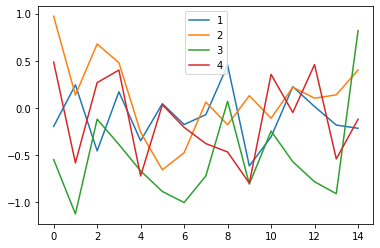

In [13]:
lineobjs = plt.plot(best_acts[0].cpu().numpy())
plt.legend(iter(lineobjs), ('1', '2', '3', '4'))

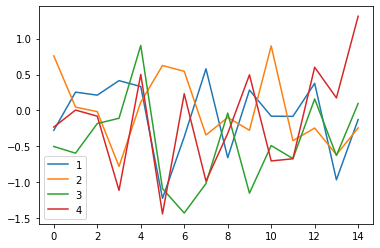

In [14]:
plt.plot(best_acts[9].cpu().numpy())
plt.legend(iter(lineobjs), ('1', '2', '3', '4'))

In [7]:
X = torch.cat(best_trajs, 0).cpu()[:,0,:]
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min) 

In [15]:
X.shape

torch.Size([160, 256])

In [9]:
best_traj.shape

NameError: name 'best_traj' is not defined

In [96]:
def plot_scatter(X_norm, im2cluster):
    plt.figure(figsize=(12, 12))
    for i in range(0,100):
        cluster_id = im2cluster[i]
        if cluster_id < 10: color = plt.cm.Set3(i)
        else: color = plt.cm.Set2(i-10)
            
        idx = i*16
        if cluster_id == 0 :
            plt.plot(X_norm[idx:idx+16, 0],X_norm[idx:idx+16, 1],'go--', color = plt.cm.Set3(0), label="Fail")

        else:
            plt.plot(X_norm[idx:idx+16, 0],X_norm[idx:idx+16, 1],'.r-', color = plt.cm.Set3(1), label="Success")
    

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.xticks([])
    plt.yticks([])
    plt.show()

IndexError: list index out of range

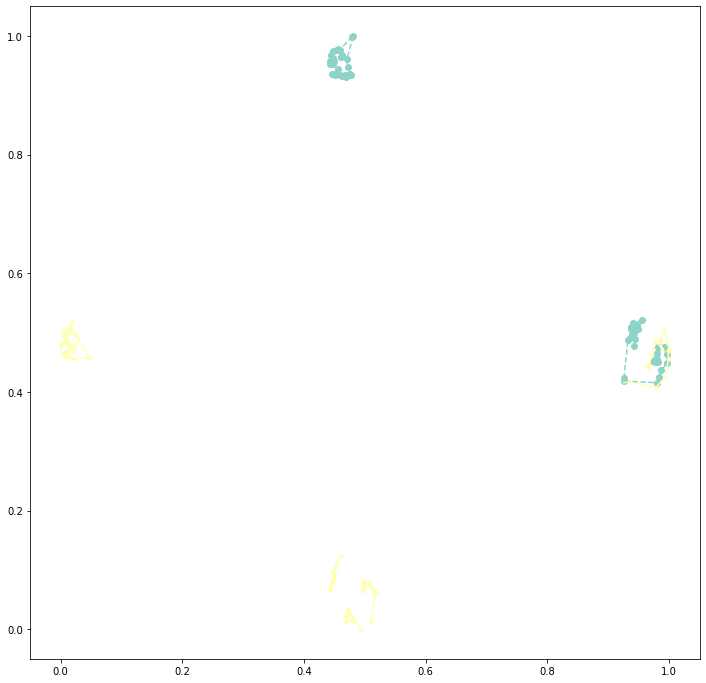

In [97]:
plot_scatter(X_norm, rewards)

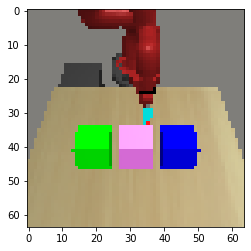

In [95]:
plt.imshow(test_env.reset().numpy()[0,0:3].transpose(1,2,0)/255)

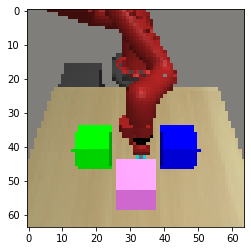

In [86]:
plt.imshow(test_env.reset().numpy()[0,3:6].transpose(1,2,0)/255)